# 1. Set up the notebook

Do imports.

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from IPython.display import display, IFrame, HTML
from ae483tools import *

Define a function to compute RMSE.

In [2]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [3]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

Define the rotation matrix $R^W_B$ as a function of the yaw angle $\psi$, the pitch angle $\theta$, and the roll angle $\phi$.

In [4]:
# Define symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define rotation about the body-fixed z axis by psi
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

# Define rotation about the body-fixed y axis by theta
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

# Define rotation about the body-fixed x axis by phi
Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

# Apply sequential transformation to compute the rotation
# matrix R_inW_ofB that describes the orientation of the drone
# (i.e., of frame B in the coordinates of frame W)
R_inW_ofB = Rz @ Ry @ Rx

# Create a function that returns R_inW_ofB as a numpy array
# given particular values of yaw, pitch, and roll
R_inW_ofB = sym.lambdify((psi, theta, phi), R_inW_ofB)

# Delete variables that are no longer needed
del psi, theta, phi, Rz, Ry, Rx

Load the parameter values $g$, $k_\text{flow}$, and $p_{z,\text{eq}}$.

In [5]:
# Load model
with open('model.json', 'r') as f:
    model = json.load(f)

# Parse model
g = model['g']
k_flow = model['k_flow']
p_z_eq = model['p_z_eq']

# Show model
print(f'g      = {g:7.4f}')
print(f'k_flow = {k_flow:7.4f}')
print(f'p_z_eq = {p_z_eq:7.4f}')

g      =  9.8100
k_flow =  4.0926
p_z_eq =  0.5000


# 2. Flight tests to debug observer implementation

## 2.1 Take-off test

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION OF YOUR FLIGHT TEST.**

Load flight data.

In [92]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab08_hover_custom_custom.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

Parse flight data:
* Estimates from the custom observer implemented online are labled `_custom`.
* Estimates from the default observer are labeled `_default`.

In [93]:
# time
t = data_drone['time']

# state estimates from custom observer
p_x_custom = data_drone['ae483log.p_x']
p_y_custom = data_drone['ae483log.p_y']
p_z_custom = data_drone['ae483log.p_z']
psi_custom = data_drone['ae483log.psi']
theta_custom = data_drone['ae483log.theta']
phi_custom = data_drone['ae483log.phi']
v_x_custom = data_drone['ae483log.v_x']
v_y_custom = data_drone['ae483log.v_y']
v_z_custom = data_drone['ae483log.v_z']

# state estimates from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])
v_x_inW_default = data_drone['stateEstimate.vx']    # <-- WARNING: in world frame
v_y_inW_default = data_drone['stateEstimate.vy']    # <-- WARNING: in world frame
v_z_inW_default = data_drone['stateEstimate.vz']    # <-- WARNING: in world frame

# desired position
p_x_des = data_drone['ae483log.p_x_des']
p_y_des = data_drone['ae483log.p_y_des']
p_z_des = data_drone['ae483log.p_z_des']

Convert the estimates of linear velocity that come from the default observer from the world frame (i.e., frame $W$) to the body frame (i.e., frame $B$) by applying the following coordinate transformation at each time step:

$$v_{W, B}^B = \left(R_B^W\right)^T v_{W, B}^W.$$

This is necessary in order to compare the estimates of linear velocity that come from the default observer to the estimates of linear velocity that come from your custom observer.

In [94]:
# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_inW_default)
v_y_default = np.empty_like(v_y_inW_default)
v_z_default = np.empty_like(v_z_inW_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame W at i'th time step from its components
    v_inW = np.array([
        v_x_inW_default[i],
        v_y_inW_default[i],
        v_z_inW_default[i],
    ])
    
    # Get v in frame B at i'th time step by coordinate transformation
    v_inB = R_inW_ofB(psi_default[i], theta_default[i], phi_default[i]).T @ v_inW
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_inB[0]
    v_y_default[i] = v_inB[1]
    v_z_default[i] = v_inB[2]

Apply offline implementation of custom observer.

**FIXME: If the observer you are implementing offline (here) is different from the observer you implemented online (in firmware, to produce this flight test), then replace this cell with a description of what you changed (e.g., weights) and why.**

In [95]:
dt = t[1] - t[0]

# Get inputs
w_x_offline = data_drone['ae483log.w_x']
w_y_offline = data_drone['ae483log.w_y']
w_z_offline = data_drone['ae483log.w_z']
a_z_offline = data_drone['ae483log.a_z']

# Get outputs
n_x_offline = data_drone['ae483log.n_x']
n_y_offline = data_drone['ae483log.n_y']
r_offline = data_drone['ae483log.r']
error_array=np.empty ((len(r_offline),3))
# Initialize estimates
p_x = 0.
p_y = 0.
p_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
p_x_offline = np.zeros(len(t))
p_y_offline = np.zeros(len(t))
p_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))
v_x_mocap= np.zeros(len(t))
v_y_mocap= np.zeros(len(t))
v_z_mocap= np.zeros(len(t))
# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    n_x_err = k_flow * (v_x / p_z_eq - w_y) - n_x
    n_y_err = k_flow * (v_y / p_z_eq + w_x) - n_y
    r_err = (p_z-p_z_eq) - (r - p_z_eq)
    # Update estimates

    p_x += dt * v_x
    p_y += dt * v_y
    p_z += dt * (v_z - 24.182550030836207 * r_err)
    psi += dt * w_z
    p_z += dt * (v_z - 24.182550030837003 * r_err)
    theta += dt * (w_y - 0.004879850801338923 * n_x_err - 1.2265369269677656e-13 * r_err)
    phi += dt * (w_x + 0.00777056452197445 * n_y_err + 6.929814426225567e-13 * r_err)
    v_x += dt * (g * theta - 0.11917589364948387 * n_x_err - 9.164164124992306e-12 * r_err)
    v_y += dt * (-g * phi - 0.14908193259386854 * n_y_err - 7.364887253554792e-12 * r_err)
    v_z += dt * (a_z - g - 113.84082632339452 * r_err)
    
    # Store estimates (do not change)
    p_x_offline[i] = p_x
    p_y_offline[i] = p_y
    p_z_offline[i] = p_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z

Compare state estimates from default and custom observers.

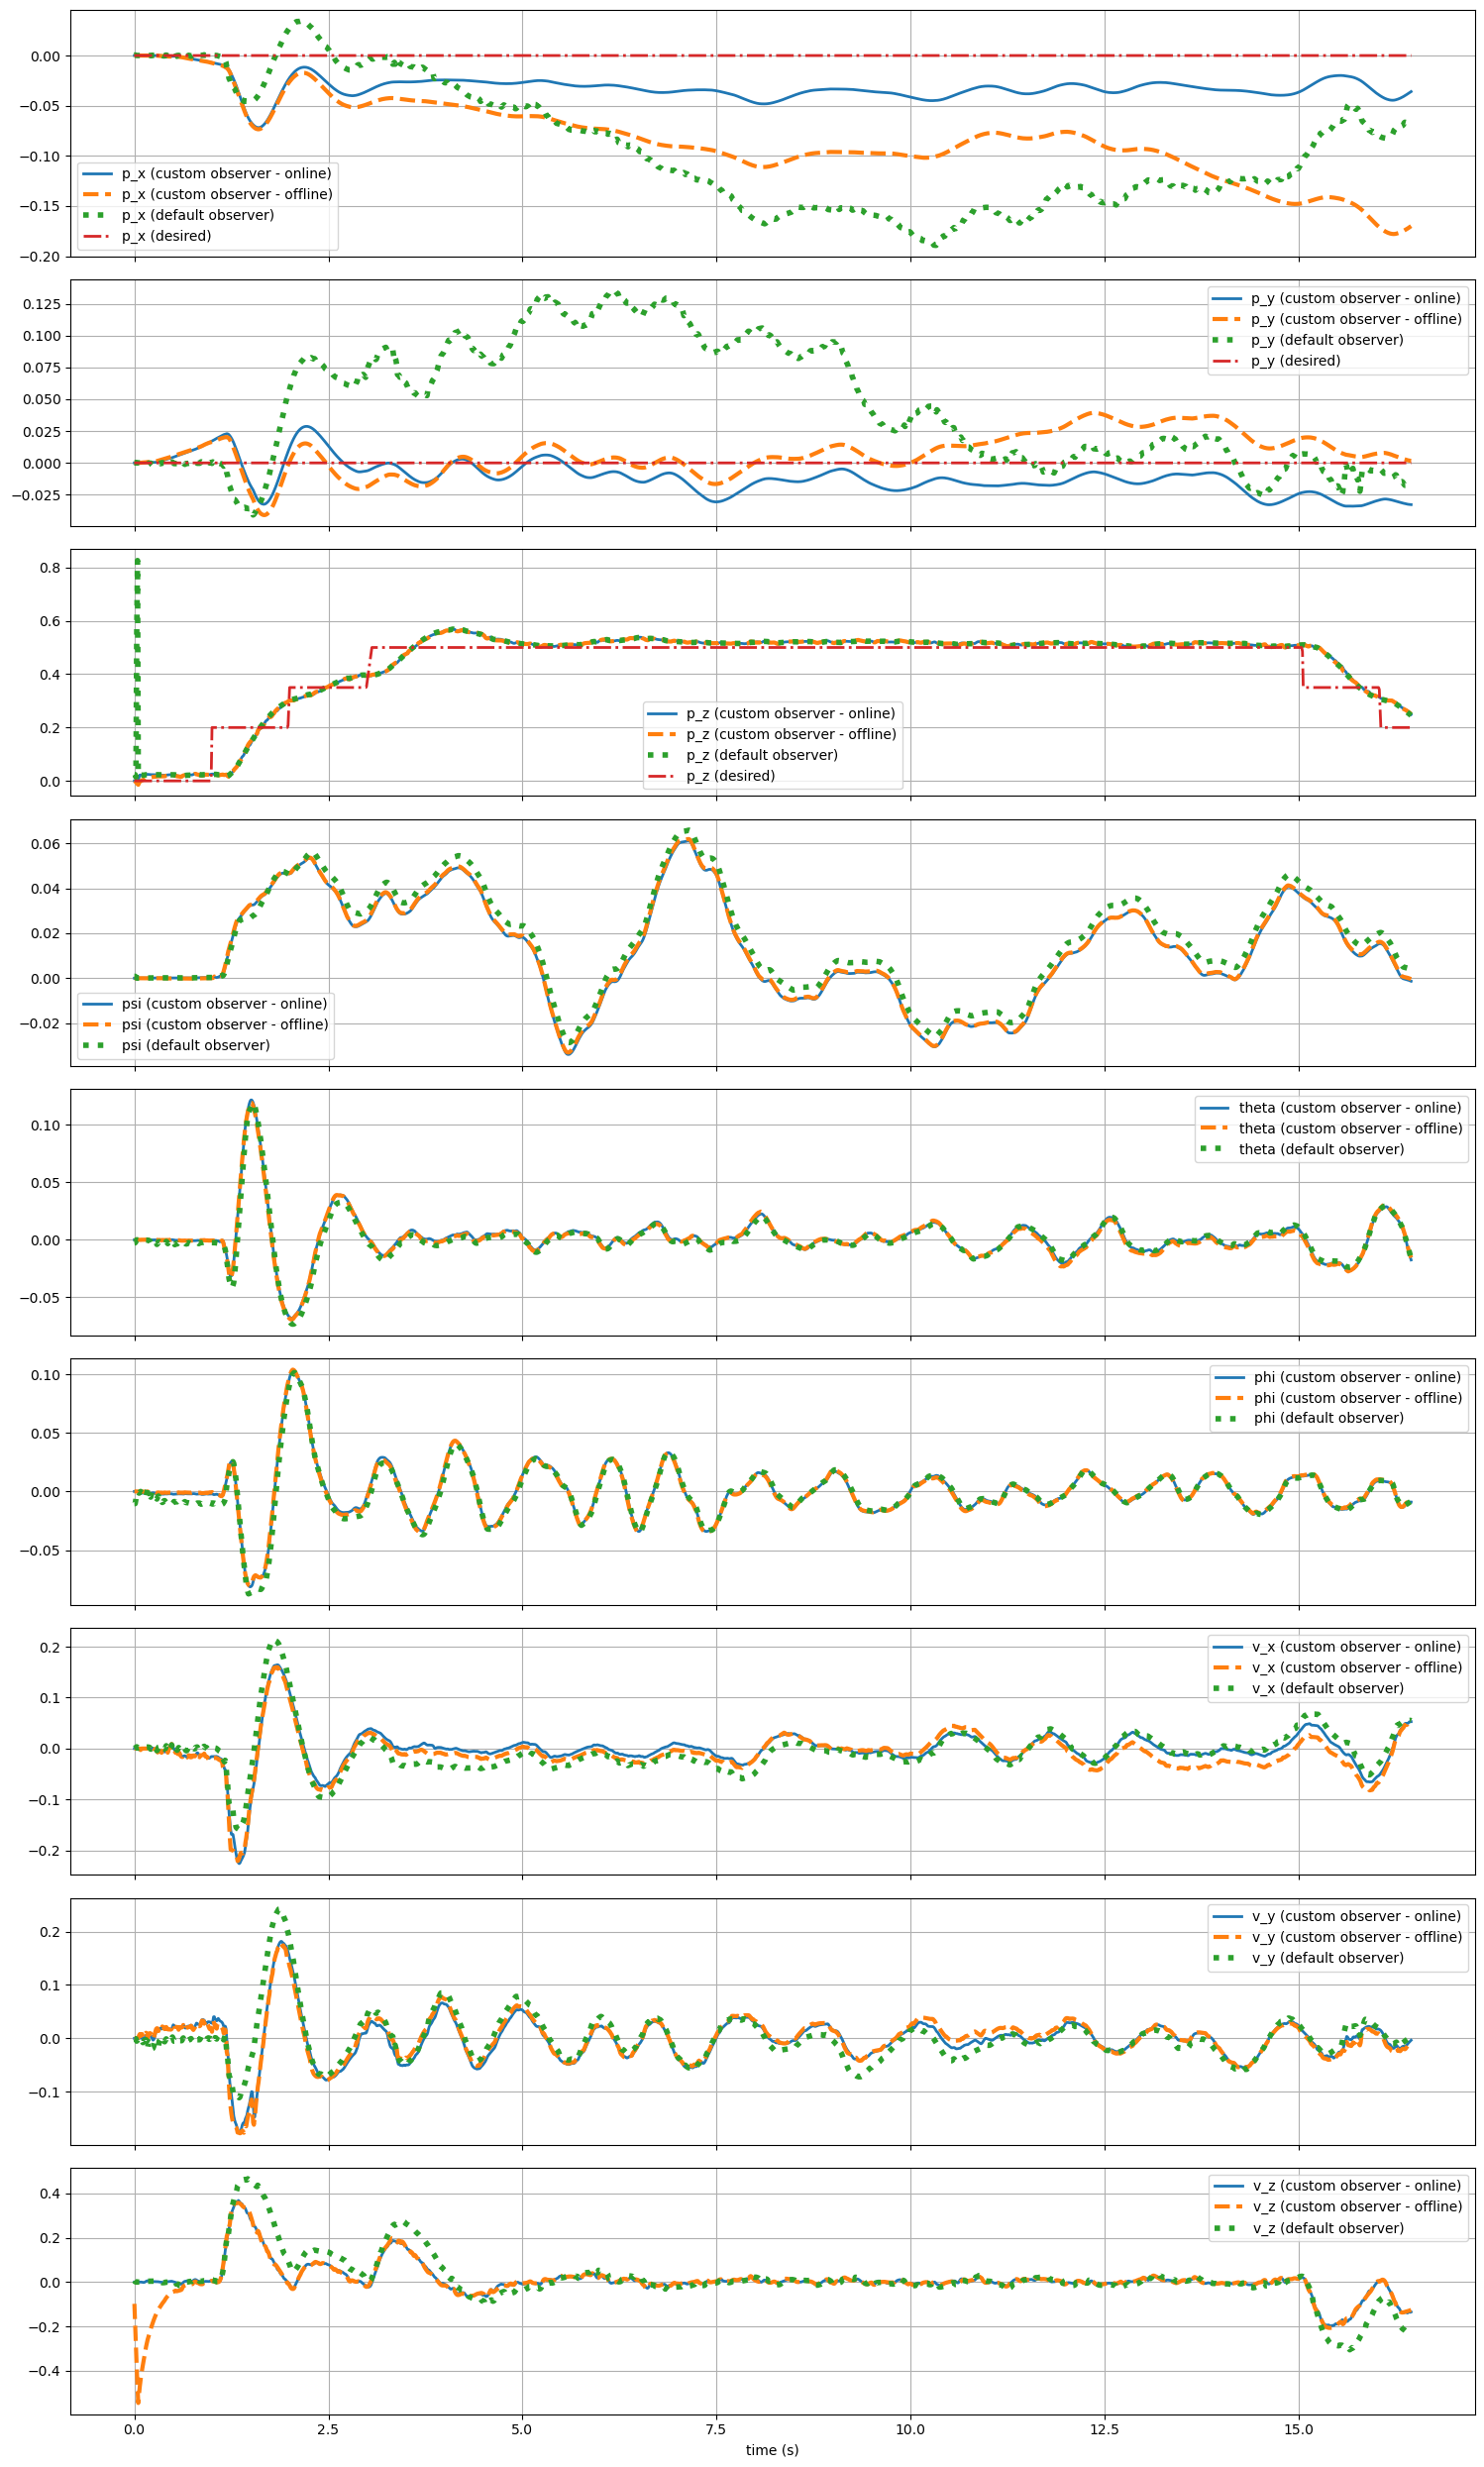

In [96]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (custom observer - online)', linewidth=2)
    ax.plot(t, s_offline, '--', label=f'{name} (custom observer - offline)', linewidth=3)
    ax.plot(t, s_default, ':', label=f'{name} (default observer)', linewidth=4)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True, tight_layout=True)

comparison_plot(t, p_x_custom, p_x_default, p_x_offline, 'p_x', ax_p_x, s_des=p_x_des)
comparison_plot(t, p_y_custom, p_y_default, p_y_offline, 'p_y', ax_p_y, s_des=p_y_des)
comparison_plot(t, p_z_custom, p_z_default, p_z_offline, 'p_z', ax_p_z, s_des=p_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

# ax_p_x.set_ylim([-0.2, 0.2])
# ax_p_y.set_ylim([-0.2, 0.2])
# ax_p_z.set_ylim([-0.05, 0.25])
# ax_psi.set_ylim([-0.1, 0.1])
# ax_theta.set_ylim([-0.25, 0.25])
# ax_phi.set_ylim([-0.25, 0.25])
# ax_v_x.set_ylim([-0.6, 0.6])
# ax_v_y.set_ylim([-0.6, 0.6])
# ax_v_z.set_ylim([-0.5, 0.5])

plt.show()

# 3. Flight tests to compare performance at hover

Define colors and styles for all plots.

In [11]:
mocap_color = 'C0'
mocap_linestyle = '-'
mocap_linewidth = 2

default_color = 'C1'
default_linestyle = '--'
default_linewidth = 2

desired_color = 'C2'
desired_linestyle = ':'
desired_linewidth = 4

custom_color = 'C3'
custom_linestyle = '-.'
custom_linewidth = 3

## 3.1 Hover with default controller and observer

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION OF YOUR FLIGHT TEST.**

Check mocap coverage.

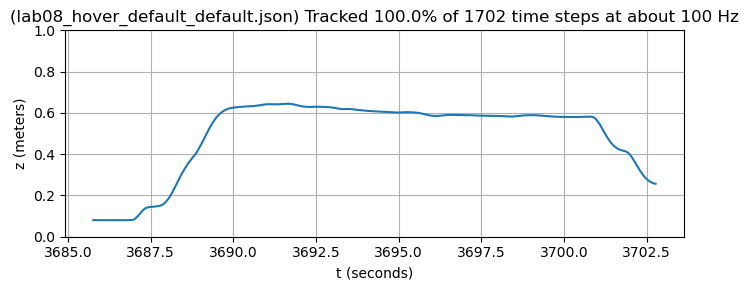

In [12]:
check_mocap_coverage('lab08_hover_default_default.json')

Load flight data.

In [98]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab08_hover_default_default.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['stateEstimate.z'])

# Only look at data from the middle 10 seconds of when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap, t_interval=14.)

Parse flight data.

Note that we have to get the desired position from `ctrltarget.x`, `ctrltarget.y`, and `ctrltarget.z` when the default controller is running. This is because `ae483log.p_x_des`, `ae483log.p_y_des`, and `ae483log.p_z_des` are only set when the custom controller is running.

In [99]:
# time
t = data_drone['time']

# position and orientation from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])

# desired position
p_x_des = data_drone['ctrltarget.x']
p_y_des = data_drone['ctrltarget.y']
p_z_des = data_drone['ctrltarget.z']

# position and orientation from the motion capture system
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

Plot position, desired position, and orientation.

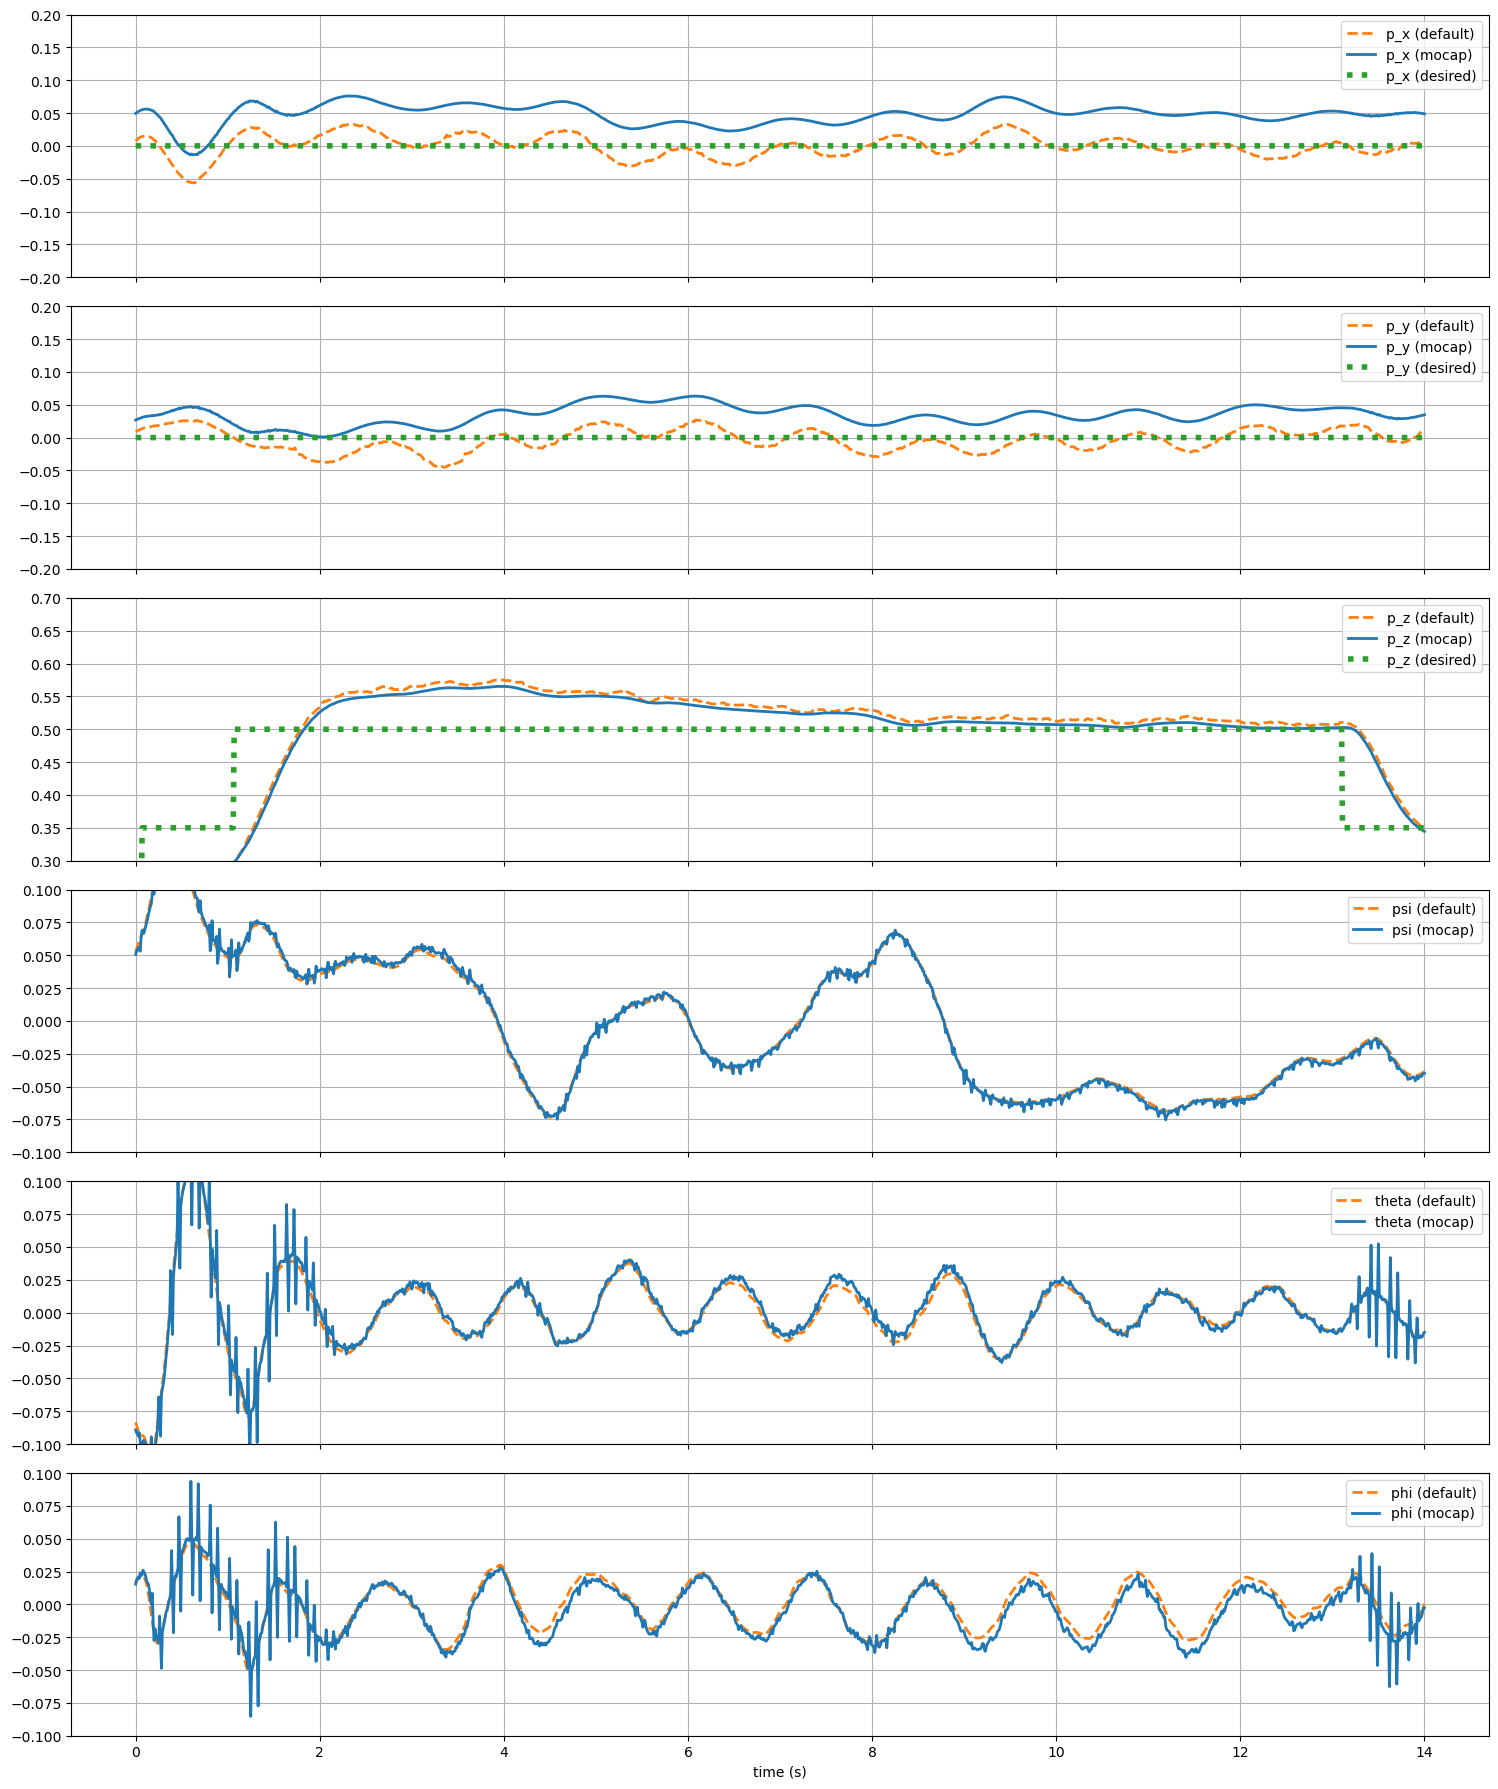

In [100]:
def comparison_plot(t, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (default)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_default, p_x_mocap, 'p_x', ax_p_x, s_des=p_x_des)
comparison_plot(t, p_y_default, p_y_mocap, 'p_y', ax_p_y, s_des=p_y_des)
comparison_plot(t, p_z_default, p_z_mocap, 'p_z', ax_p_z, s_des=p_z_des)
comparison_plot(t, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
ax_p_x.set_ylim([-0.2, 0.2])
ax_p_y.set_ylim([-0.2, 0.2])
ax_p_z.set_ylim([0.3, 0.7])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.1, 0.1])
ax_phi.set_ylim([-0.1, 0.1])
plt.show()

Compute RMSE between states (from default observer) and their desired values.

In [101]:
print(f'RMSE from t={t[0]} to t={t[-1]} (using estimates from default observer):')
print(f' p_x:   {rmse(p_x_default, p_x_des):7.3f}')
print(f' p_y:   {rmse(p_y_default, p_y_des):7.3f}')
print(f' p_z:   {rmse(p_z_default, p_z_des):7.3f}')
print(f' psi:   {rmse(psi_default, 0.):7.3f}')
print(f' theta: {rmse(theta_default, 0.):7.3f}')
print(f' phi:   {rmse(phi_default, 0.):7.3f}')

RMSE from t=0.0 to t=14.0 (using estimates from default observer):
 p_x:     0.017
 p_y:     0.017
 p_z:     0.074
 psi:     0.049
 theta:   0.028
 phi:     0.018


Compute RMSE between states (from mocap) and their desired values.

In [102]:
print(f'RMSE from t={t[0]} to t={t[-1]} (using estimates from mocap):')
print(f' p_x:   {rmse(p_x_mocap, p_x_des):7.3f}')
print(f' p_y:   {rmse(p_y_mocap, p_y_des):7.3f}')
print(f' p_z:   {rmse(p_z_mocap, p_z_des):7.3f}')
print(f' psi:   {rmse(psi_mocap, 0.):7.3f}')
print(f' theta: {rmse(theta_mocap, 0.):7.3f}')
print(f' phi:   {rmse(phi_mocap, 0.):7.3f}')

RMSE from t=0.0 to t=14.0 (using estimates from mocap):
 p_x:     0.050
 p_y:     0.037
 p_z:     0.072
 psi:     0.051
 theta:   0.030
 phi:     0.021


## 3.2 Hover with custom controller and default observer

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION OF YOUR FLIGHT TEST.**

Check mocap coverage.

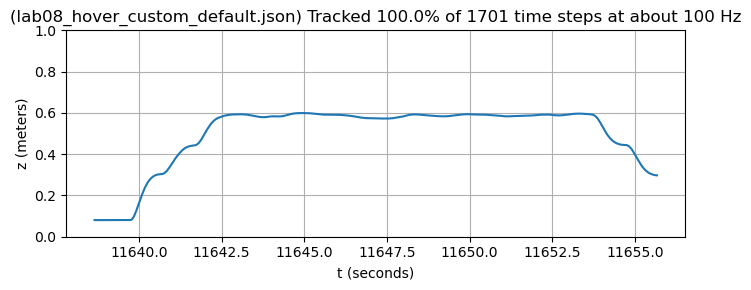

In [103]:
check_mocap_coverage('lab08_hover_custom_default.json')

Load flight data.

In [104]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab08_hover_custom_default.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from the middle 10 seconds of when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap, t_interval=10.)

Parse flight data.

In [105]:
# time
t = data_drone['time']

# position and orientation from default observer
p_x_default = data_drone['ae483log.p_x']
p_y_default = data_drone['ae483log.p_y']
p_z_default = data_drone['ae483log.p_z']
psi_default = data_drone['ae483log.psi']
theta_default = data_drone['ae483log.theta']
phi_default = data_drone['ae483log.phi']

# desired position
p_x_des = data_drone['ae483log.p_x_des']
p_y_des = data_drone['ae483log.p_y_des']
p_z_des = data_drone['ae483log.p_z_des']

# position and orientation from the motion capture system
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

Plot position, desired position, and orientation.

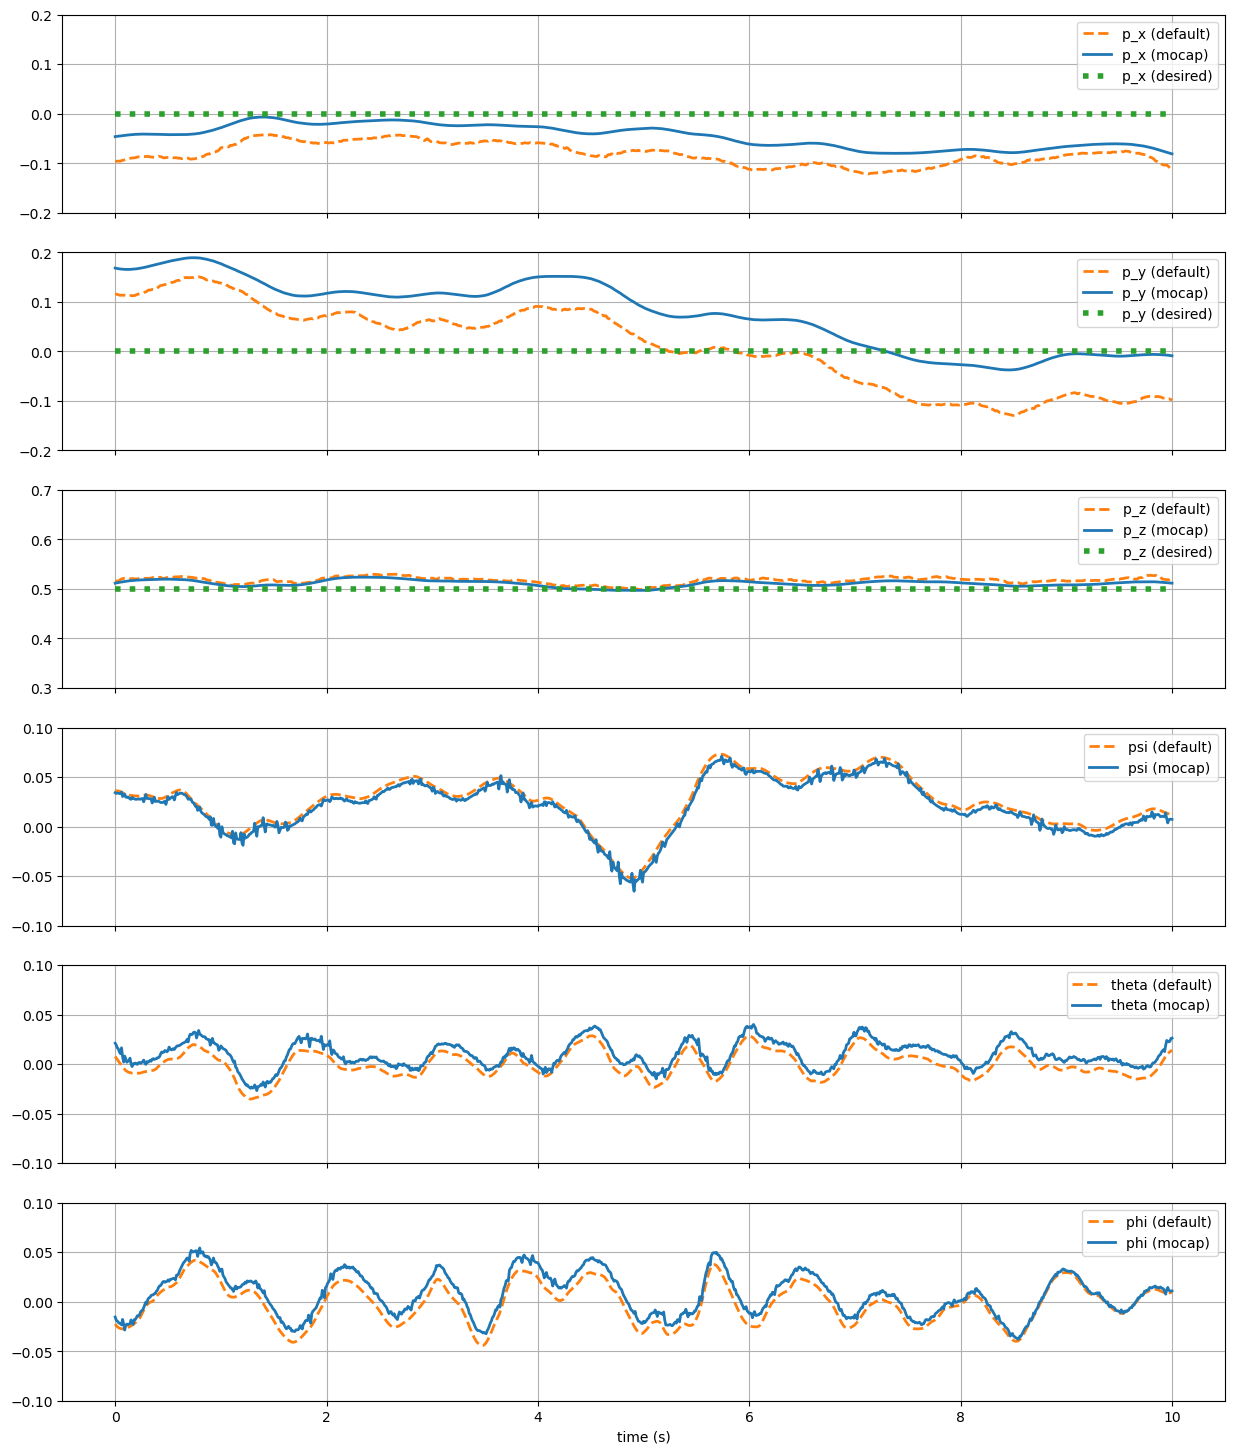

In [106]:
def comparison_plot(t, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (default)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True)
comparison_plot(t, p_x_default, p_x_mocap, 'p_x', ax_p_x, s_des=p_x_des)
comparison_plot(t, p_y_default, p_y_mocap, 'p_y', ax_p_y, s_des=p_y_des)
comparison_plot(t, p_z_default, p_z_mocap, 'p_z', ax_p_z, s_des=p_z_des)
comparison_plot(t, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
ax_p_x.set_ylim([-0.2, 0.2])
ax_p_y.set_ylim([-0.2, 0.2])
ax_p_z.set_ylim([0.3, 0.7])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.1, 0.1])
ax_phi.set_ylim([-0.1, 0.1])
plt.show()

Compute RMSE between states (from default observer) and their desired values.

In [107]:
print(f'RMSE from t={t[0]} to t={t[-1]} (using estimates from default observer):')
print(f' p_x:   {rmse(p_x_default, p_x_des):7.3f}')
print(f' p_y:   {rmse(p_y_default, p_y_des):7.3f}')
print(f' p_z:   {rmse(p_z_default, p_z_des):7.3f}')
print(f' psi:   {rmse(psi_default, 0.):7.3f}')
print(f' theta: {rmse(theta_default, 0.):7.3f}')
print(f' phi:   {rmse(phi_default, 0.):7.3f}')

RMSE from t=0.0 to t=10.0 (using estimates from default observer):
 p_x:     0.084
 p_y:     0.084
 p_z:     0.019
 psi:     0.036
 theta:   0.013
 phi:     0.021


Compute RMSE between states (from mocap) and their desired values.

In [108]:
print(f'RMSE from t={t[0]} to t={t[-1]} (using estimates from mocap):')
print(f' p_x:   {rmse(p_x_mocap, p_x_des):7.3f}')
print(f' p_y:   {rmse(p_y_mocap, p_y_des):7.3f}')
print(f' p_z:   {rmse(p_z_mocap, p_z_des):7.3f}')
print(f' psi:   {rmse(psi_mocap, 0.):7.3f}')
print(f' theta: {rmse(theta_mocap, 0.):7.3f}')
print(f' phi:   {rmse(phi_mocap, 0.):7.3f}')

RMSE from t=0.0 to t=10.0 (using estimates from mocap):
 p_x:     0.051
 p_y:     0.104
 p_z:     0.013
 psi:     0.033
 theta:   0.016
 phi:     0.022


## 3.3 Hover with custom controller and observer

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION OF YOUR FLIGHT TEST.**

Check mocap coverage.

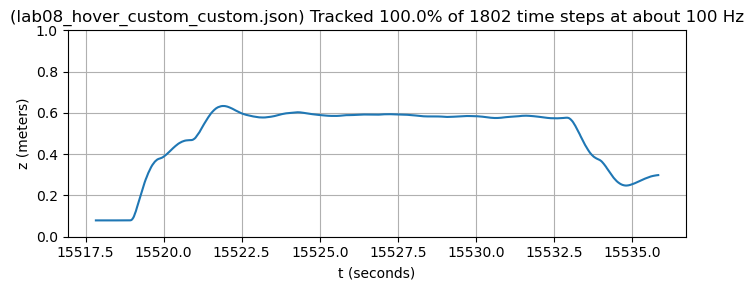

In [109]:
check_mocap_coverage('lab08_hover_custom_custom.json')

Load flight data.

In [113]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab08_hover_custom_custom.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from the middle 10 seconds of when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap, t_interval=10.)

Parse flight data:
* Estimates from the custom observer implemented online are labled `_custom`.
* Estimates from the default observer are labeled `_default`.

In [114]:
# time
t = data_drone['time']

# position and orientation from custom observer
p_x_custom = data_drone['ae483log.p_x']
p_y_custom = data_drone['ae483log.p_y']
p_z_custom = data_drone['ae483log.p_z']
psi_custom = data_drone['ae483log.psi']
theta_custom = data_drone['ae483log.theta']
phi_custom = data_drone['ae483log.phi']
v_x_custom = data_drone['ae483log.v_x']
v_y_custom = data_drone['ae483log.v_y']

# position and orientation from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])
v_x_default = data_drone['stateEstimate.vx']
v_y_default = data_drone['stateEstimate.vy']

# desired position
p_x_des = data_drone['ae483log.p_x_des']
p_y_des = data_drone['ae483log.p_y_des']
p_z_des = data_drone['ae483log.p_z_des']

# position and orientation from the motion capture system
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']
# v_x_mocap = data_mocap['vx']
# v_y_mocap = data_mocap['vy']

Plot position, desired position, and orientation.

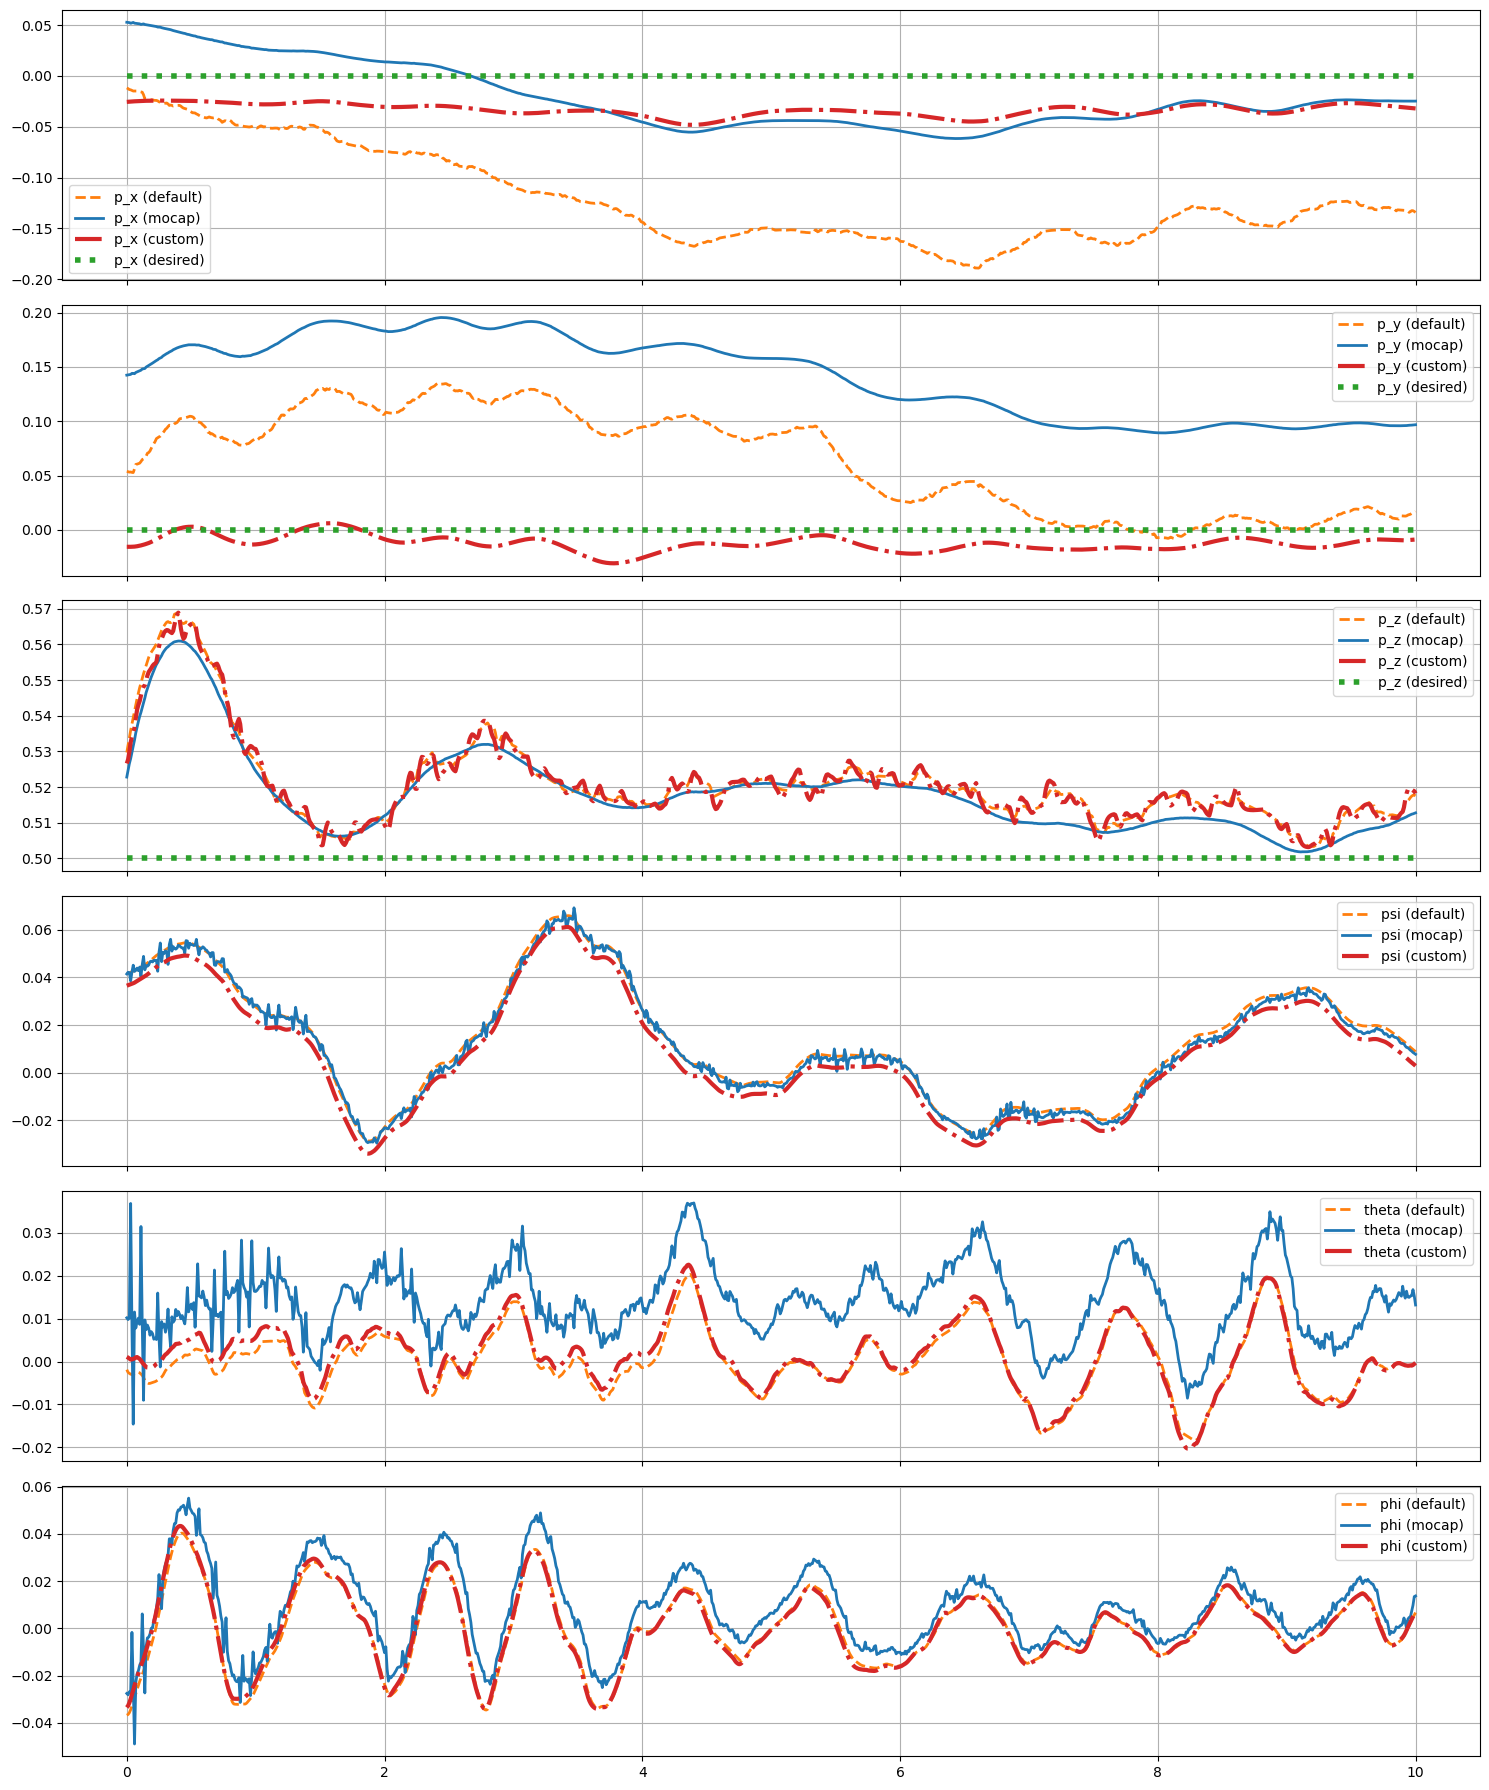

In [115]:
def comparison_plot(t, s_custom, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (default)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    ax.plot(t, s_custom, label=f'{name} (custom)',
            color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_custom, p_x_default, p_x_mocap, 'p_x', ax_p_x, s_des=p_x_des)
comparison_plot(t, p_y_custom, p_y_default, p_y_mocap, 'p_y', ax_p_y, s_des=p_y_des)
comparison_plot(t, p_z_custom, p_z_default, p_z_mocap, 'p_z', ax_p_z, s_des=p_z_des)
comparison_plot(t, psi_custom, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_mocap, 'phi', ax_phi)
# comparison_plot(t, v_x_custom, v_x_default, 0, 'v_x', ax_v_x)
# comparison_plot(t, v_y_custom, v_y_default, 0, 'v_y', ax_v_y)
# ax_phi.set_xlabel('time (s)')
# ax_p_x.set_ylim([-0.2, 0.2])
# ax_p_y.set_ylim([-0.2, 0.2])
# ax_p_z.set_ylim([0.3, 0.7])
# ax_psi.set_ylim([-0.1, 0.1])
# ax_theta.set_ylim([-0.1, 0.1])
# ax_phi.set_ylim([-0.1, 0.1])
plt.show()

Compute RMSE between states (from custom observer) and their desired values.

In [116]:
print(f'RMSE from t={t[0]} to t={t[-1]} (using estimates from default observer):')
print(f' p_x:   {rmse(p_x_custom, p_x_des):7.3f}')
print(f' p_y:   {rmse(p_y_custom, p_y_des):7.3f}')
print(f' p_z:   {rmse(p_z_custom, p_z_des):7.3f}')
print(f' psi:   {rmse(psi_custom, 0.):7.3f}')
print(f' theta: {rmse(theta_custom, 0.):7.3f}')
print(f' phi:   {rmse(phi_custom, 0.):7.3f}')

RMSE from t=0.0 to t=10.0 (using estimates from default observer):
 p_x:     0.034
 p_y:     0.014
 p_z:     0.024
 psi:     0.026
 theta:   0.008
 phi:     0.016


Compute RMSE between states (from mocap) and their desired values.

In [117]:
print(f'RMSE from t={t[0]} to t={t[-1]} (using estimates from mocap):')
print(f' p_x:   {rmse(p_x_mocap, p_x_des):7.3f}')
print(f' p_y:   {rmse(p_y_mocap, p_y_des):7.3f}')
print(f' p_z:   {rmse(p_z_mocap, p_z_des):7.3f}')
print(f' psi:   {rmse(psi_mocap, 0.):7.3f}')
print(f' theta: {rmse(theta_mocap, 0.):7.3f}')
print(f' phi:   {rmse(phi_mocap, 0.):7.3f}')

RMSE from t=0.0 to t=10.0 (using estimates from mocap):
 p_x:     0.038
 p_y:     0.146
 p_z:     0.022
 psi:     0.027
 theta:   0.016
 phi:     0.019


## 3.4 Summary and discussion

RMSE in each component of position and of orientation **(computed with respect to state estimates from an observer)**:

|  | $p_x$ | $p_y$ | $p_z$ | $\psi$ | $\theta$ | $\phi$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE in hover test (default controller, default observer) | 0.017 | 0.024 | 0.047 | 0.032 | 0.019 | 0.018 |
| RMSE in hover test (custom controller, default observer) | 0.087 | 0.055 | 0.011 | 0.028 | 0.013 | 0.033 |
| RMSE in move test (custom controller, custom observer) | 0.056 | 0.056 | 0.007 | 0.021 | 0.012 | 0.021 |

**Modify the text in this cell** to answer the following questions:

* Are you able to match the performance of the default controller and observer (top row) with your controller and observer (bottom row)? Do the results when using the custom controller with the default observer (middle row) help explain any differences in performance?
* What about your observer design (if anything) did you have to change in order to get your custom controller and observer to work well? Why were these changes necessary?

RMSE in each component of position and of orientation **(computed with respect to state estimates from mocap)**:

|  | $p_x$ | $p_y$ | $p_z$ | $\psi$ | $\theta$ | $\phi$ |
| --: | :--: | :--: | :--: | :--: | :--: | :--: |
| RMSE in hover test (default controller, default observer) | 0.050 | 0.037 | 0.072 | 0.051 | 0.030 | 0.021 |
| RMSE in hover test (custom controller, default observer) | 0.051 | 0.104 | 0.013 | 0.033 | 0.016 | 0.022 |
| RMSE in move test (custom controller, custom observer) | 0.038 | 0.146 | 0.022 | 0.027 | 0.016 | 0.019 |

**Modify the text in this cell** to answer the following questions:

* In what ways are the RMSE values in this table (computed with respect to state estimates from mocap) significantly different from the RMSE values in the other table (computed with respect to state estimates from an observer)? Why?

# 4. Flight test while moving in squares

Check mocap coverage.

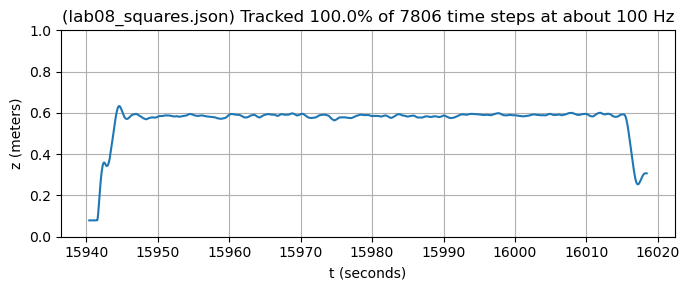

In [118]:
check_mocap_coverage('lab08_squares.json')

Load flight data.

In [119]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab08_squares.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap)

Parse flight data.

In [124]:
# flight test data
# data = resample_data_drone(raw_data_drone, only_in_flight=True)
data = data_drone

# times
t = data['time']

# position and orientation from default observer
p_x_default = data['stateEstimate.x']
p_y_default = data['stateEstimate.y']
p_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = -np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])

# position and orientation from custom observer
p_x_custom = data['ae483log.p_x']
p_y_custom = data['ae483log.p_y']
p_z_custom = data['ae483log.p_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']

# desired position
p_x_des = data['ae483log.p_x_des']
p_y_des = data['ae483log.p_y_des']
p_z_des = data['ae483log.p_z_des']

# position and orientation from the motion capture system
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

Plot position, desired position, and orientation (both from default and custom observer) as functions of time.

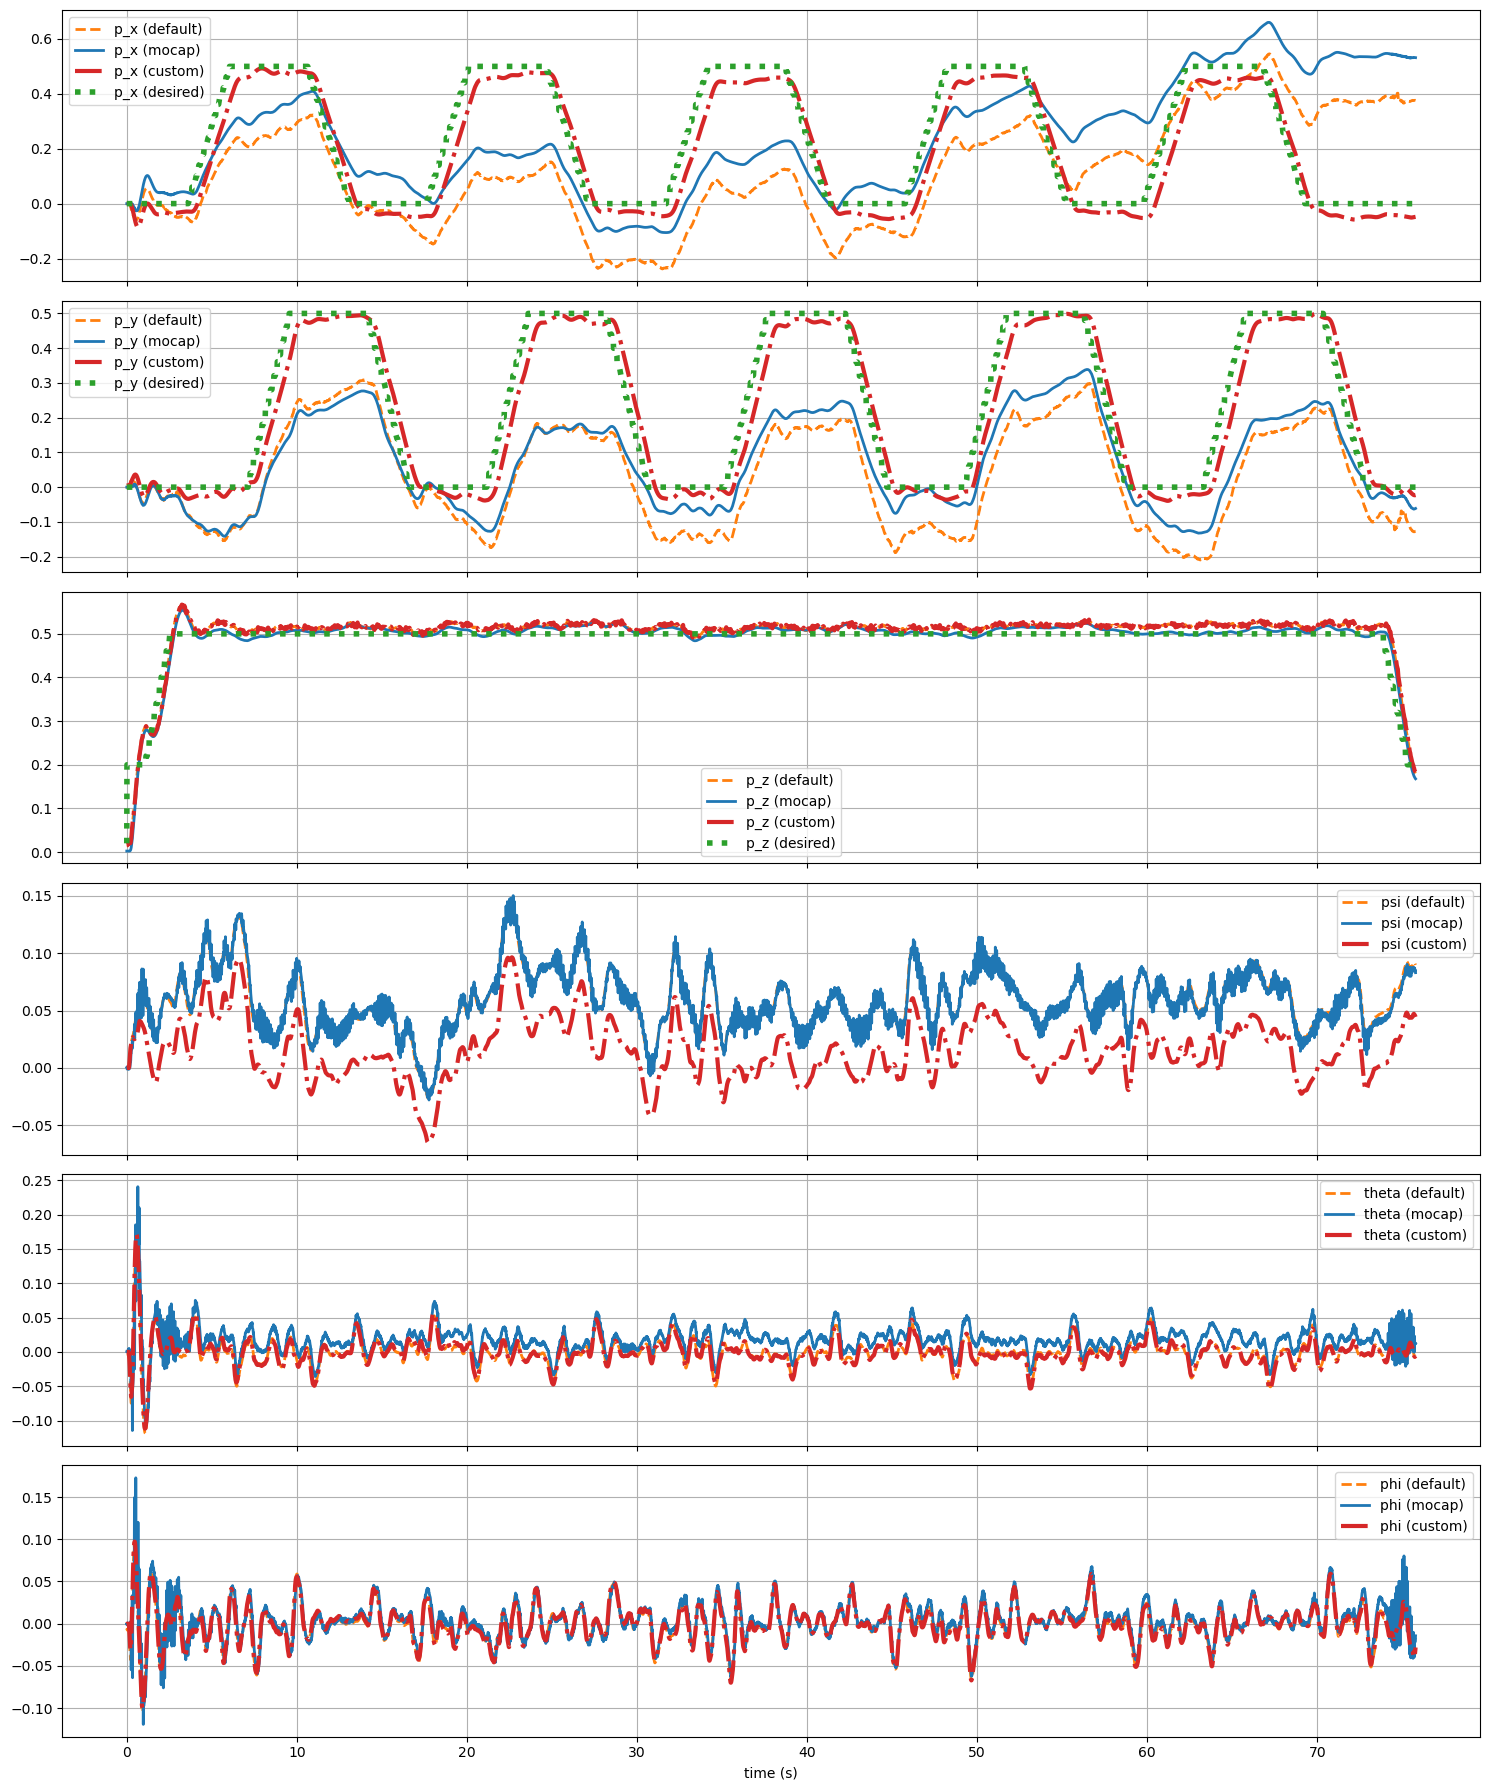

In [125]:
def comparison_plot(t, s_custom, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (default)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    ax.plot(t, s_custom, label=f'{name} (custom)',
            color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_custom, p_x_default, p_x_mocap, 'p_x', ax_p_x, s_des=p_x_des)
comparison_plot(t, p_y_custom, p_y_default, p_y_mocap, 'p_y', ax_p_y, s_des=p_y_des)
comparison_plot(t, p_z_custom, p_z_default, p_z_mocap, 'p_z', ax_p_z, s_des=p_z_des)
comparison_plot(t, psi_custom, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

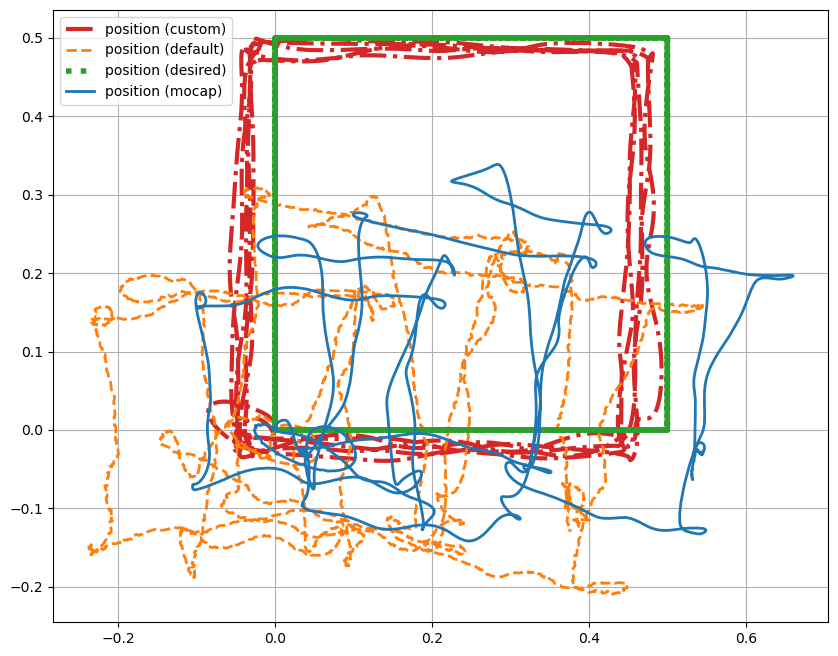

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(p_x_custom, p_y_custom, label='position (custom)',
         color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
ax.plot(p_x_default, p_y_default, label='position (default)',
         color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
ax.plot(p_x_des, p_y_des, label='position (desired)',
         color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
ax.plot(p_x_mocap, p_y_mocap, label='position (mocap)',
         color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION OF YOUR FLIGHT TEST.**

Also, in the following cell, show a video of your hardware flight test (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

**Modify the text in this cell** to explain what is going on in the video and in the plots. What happens over time to the state estimates from the default and custom observers, relative to the state estimates from the motion capture system? Is the drone really flying in squares? To what extent is the custom controller working well? To what extent is the custom observer working well? How could you improve performance? What is possible to improve, and what is impossible to improve, given the available sensors?